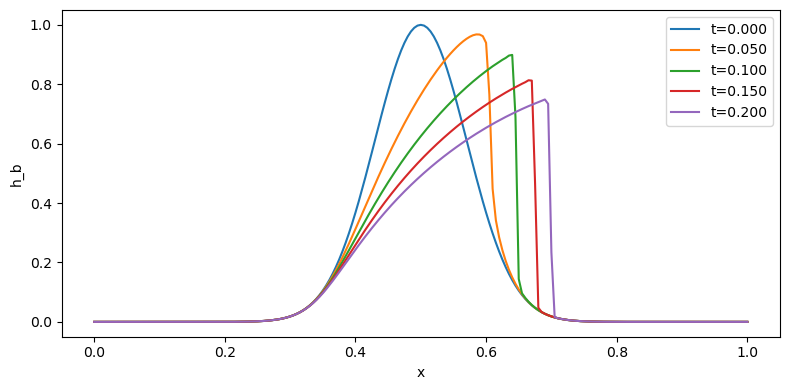

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# ————————————————
# 参数定义
# ————————————————
L      = 1.0        # 域长度
nx     = 201        # 网格点数
dx     = L/(nx-1)
x      = np.linspace(0, L, nx)

H0     = 1.0        # H(x) 的标度
rho_w  = 1000.      # 水密度 kg/m^3
g      = 9.81       # 重力加速度 m/s^2
mu_eff = 1e3        # 有效粘度 Pa·s
k      = rho_w * g / (12 * mu_eff)

# 正则化 H'(x)，避免奇异
eps = 1e-6
Hp = -H0/(2*L) * (1 - x/L + eps)**(-0.5)

# 初始条件：高斯脊
h0 = np.exp(-((x - 0.5*L)/(0.1*L))**2)

# WENO5 重构导数函数
def weno5_flux_derivative(f):
    eps_w = 1e-6
    # extend ghost cells by zero-gradient
    fg = np.zeros(len(f) + 4)
    fg[2:-2] = f
    fg[:2]  = f[0]
    fg[-2:] = f[-1]
    # compute left-biased flux at interfaces
    def compute_flux(arr):
        f0, f1, f2, f3, f4 = arr
        p0 = (2*f0 - 7*f1 + 11*f2) / 6
        p1 = (-f1 + 5*f2 + 2*f3) / 6
        p2 = (2*f2 + 5*f3 - f4) / 6
        β0 = 13/12*(f0 - 2*f1 + f2)**2 + 1/4*(f0 - 4*f1 + 3*f2)**2
        β1 = 13/12*(f1 - 2*f2 + f3)**2 + 1/4*(f1 - f3)**2
        β2 = 13/12*(f2 - 2*f3 + f4)**2 + 1/4*(3*f2 - 4*f3 + f4)**2
        α0 = 0.1    / (eps_w + β0)**2
        α1 = 0.6    / (eps_w + β1)**2
        α2 = 0.3    / (eps_w + β2)**2
        αsum = α0 + α1 + α2
        w0, w1, w2 = α0/αsum, α1/αsum, α2/αsum
        return w0*p0 + w1*p1 + w2*p2
    # reconstruct interface fluxes
    fL = np.array([compute_flux(fg[i:i+5]) for i in range(len(fg)-4)])
    # compute derivative at centers, pad zero at left boundary
    dfdx_int = (fL[1:] - fL[:-1]) / dx  # length nx-1
    dfdx = np.zeros_like(f)
    dfdx[1:] = dfdx_int
    return dfdx

# 右侧算子
def rhs(h):
    F = k * h**3 * Hp
    return weno5_flux_derivative(F)

# 时间积分：TVD RK3
dt    = 1e-4
t_max = 0.2
nt    = int(t_max/dt)
times = [0, t_max/4, t_max/2, 3*t_max/4, t_max]

# 记录
h = h0.copy()
h_record = {t: h.copy() if t==0 else None for t in times}

for n in range(1, nt+1):
    k1 = rhs(h)
    h1 = h + dt * k1
    k2 = rhs(h1)
    h2 = 3/4*h + 1/4*(h1 + dt*k2)
    k3 = rhs(h2)
    h = 1/3*h + 2/3*(h2 + dt*k3)

    t = n*dt
    for tp in times:
        if abs(t-tp) < dt/2:
            h_record[tp] = h.copy()

# 绘图
plt.figure(figsize=(8,4))
for tp in sorted(h_record.keys()):
    plt.plot(x, h_record[tp], label=f't={tp:.3f}')
plt.xlabel('x')
plt.ylabel('h_b')
plt.legend()
plt.tight_layout()
plt.show()


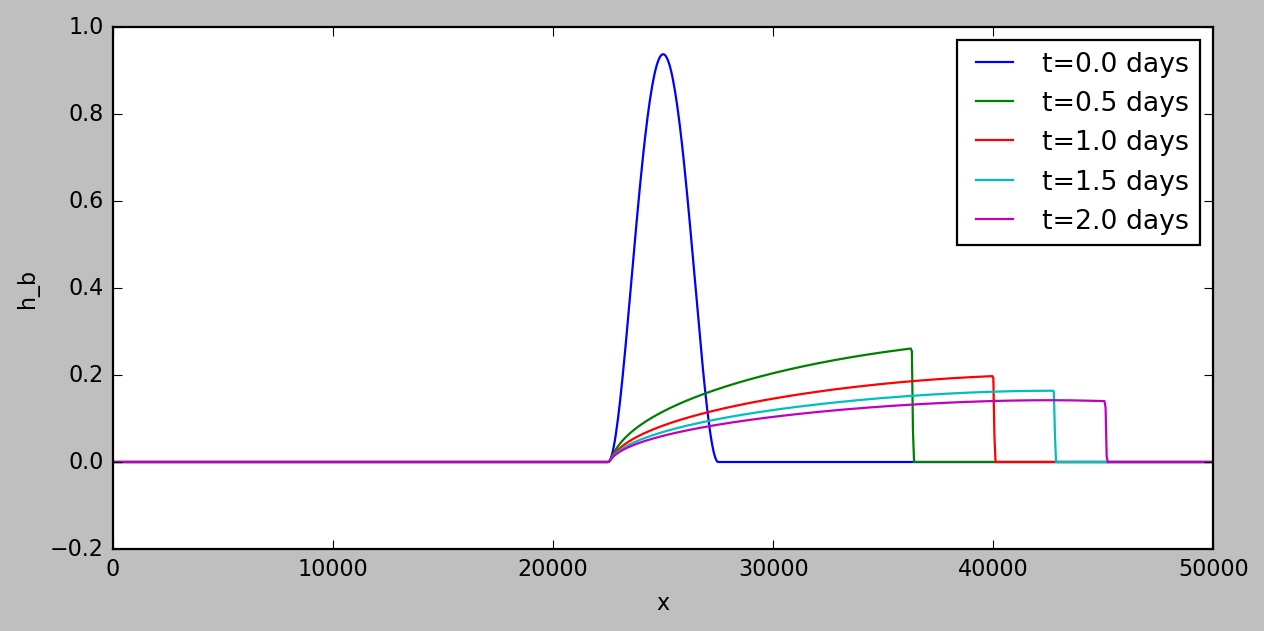

In [98]:
# Dimensional simulation of a glacier hydrology model using WENO5 reconstruction for flux derivatives.
# This code simulates the evolution of water thickness in a glacier hydrology system over time,
# using a WENO5 scheme for accurate flux calculations. The model parameters and initial conditions
# are defined, and the simulation runs for a specified duration, recording the state at various time points.
# Finally, it visualizes the results using matplotlib.
# This code is a Python adaptation of a glacier hydrology model

import numpy as np
import matplotlib.pyplot as plt

# ————————————————
# Dimensional parameters
# ————————————————
L      = 5e4        # domain length in meters
nx     = 1001        # number of grid points
dx     = L/(nx-1)   # grid spacing
x      = np.linspace(0, L, nx)

H0     = 1e3        # H at x=0 in meters
rho_w  = 1000.      # water density in kg/m^3
g      = 9.81       # gravitational acceleration in m/s^2
mu_eff = 1e1        # effective viscosity in Pa·s
k      = rho_w * g / (12 * mu_eff)

# time integration: TVD RK3
td   =  24*3600          # one day in seconds
t_max = 2.0*td          # maximum time in seconds
dt    = t_max / 10000   # time step in seconds
nt    = int(t_max/dt)
times = [0, t_max/4, t_max/2, 3*t_max/4, t_max]

# Scales
# l0 = 1e3  # length scale in meters
# t0 = 1e2  # time scale in seconds

# regularize H'(x) to avoid singularities
eps = 1e-14
Hp = -H0/(2*L) * (1 - x/L + eps)**(-0.5)

# initial condition: Gaussian ridge
Vl = 2.5e3  # initial volume in m^3
R = 2.5e3  # initial radius in meters
h0 = (np.abs(x-0.5*L)<R)*(15*Vl/(16*R))*(1-((x - 0.5*L)/R)**2)**2

# WENO5 reconstruction derivative function
def weno5_flux_derivative(f):
    eps_w = 1e-6
    # extend ghost cells by zero-gradient
    fg = np.zeros(len(f) + 4)
    fg[2:-2] = f
    fg[:2]  = f[0]
    fg[-2:] = f[-1]
    # compute left-biased flux at interfaces
    def compute_flux(arr):
        f0, f1, f2, f3, f4 = arr
        p0 = (2*f0 - 7*f1 + 11*f2) / 6
        p1 = (-f1 + 5*f2 + 2*f3) / 6
        p2 = (2*f2 + 5*f3 - f4) / 6
        b0 = 13/12*(f0 - 2*f1 + f2)**2 + 1/4*(f0 - 4*f1 + 3*f2)**2
        b1 = 13/12*(f1 - 2*f2 + f3)**2 + 1/4*(f1 - f3)**2
        b2 = 13/12*(f2 - 2*f3 + f4)**2 + 1/4*(3*f2 - 4*f3 + f4)**2
        a0 = 0.1    / (eps_w + b0)**2
        a1 = 0.6    / (eps_w + b1)**2
        a2 = 0.3    / (eps_w + b2)**2
        asum = a0 + a1 + a2
        w0, w1, w2 = a0/asum, a1/asum, a2/asum
        return w0*p0 + w1*p1 + w2*p2
    # reconstruct interface fluxes
    fL = np.array([compute_flux(fg[i:i+5]) for i in range(len(fg)-4)])
    # compute derivative at centers, pad zero at left boundary
    dfdx_int = (fL[1:] - fL[:-1]) / dx  # length nx-1
    dfdx = np.zeros_like(f)
    dfdx[1:] = dfdx_int
    return dfdx

# flux function
def rhs(h):
    F = k * h**3 * Hp
    return weno5_flux_derivative(F)

# 记录
h = h0.copy()
h_record = {t: h.copy() if t==0 else None for t in times}

for n in range(1, nt+1):
    k1 = rhs(h)
    h1 = h + dt * k1
    k2 = rhs(h1)
    h2 = 3/4*h + 1/4*(h1 + dt*k2)
    k3 = rhs(h2)
    h = 1/3*h + 2/3*(h2 + dt*k3)

    t = n*dt
    for tp in times:
        if abs(t-tp) < dt/2:
            h_record[tp] = h.copy()

# 绘图
plt.figure(figsize=(8,4))
for tp in sorted(h_record.keys()):
    plt.plot(x, h_record[tp], label=f't={tp/td:.1f} days')
plt.xlabel('x')
plt.ylabel('h_b') 
plt.legend()
plt.tight_layout()
plt.show()


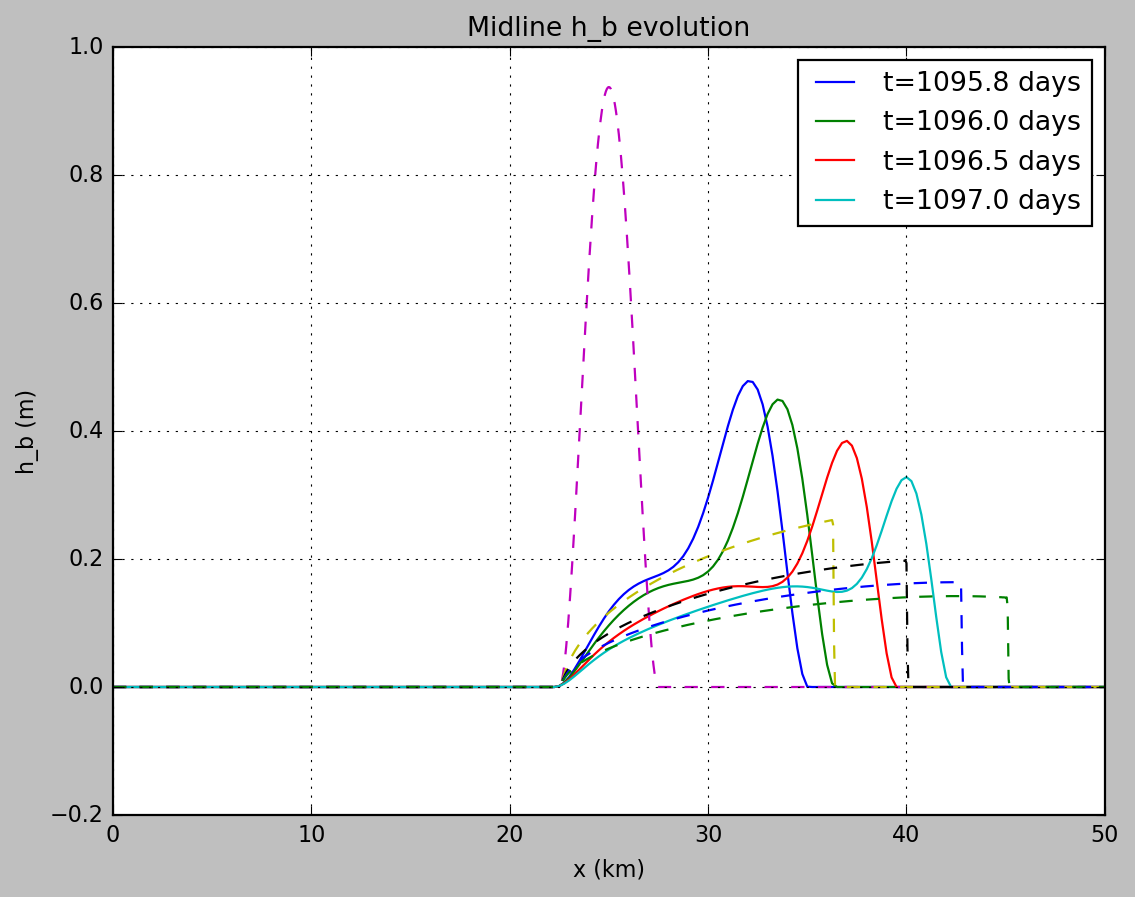

In [105]:
import os
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# --- Import data ---------------------------------------------------------
casename = 'n2d_0m3s_alpha1e_5_kappa1e_10_mu1e1_V1e7_highres'
mat_path = os.path.join('results', casename, casename + '.mat')
raw      = sio.loadmat(mat_path, squeeze_me=True)

tt = raw['tt']
ps = raw['ps']
pp = raw['pp']
oo = raw['oo']
pd = raw['pd']
aa = raw['aa']
gg = raw['gg']

# 将关键参数转换为数值类型
ps_t   = np.float64(ps['t'])
pd_td  = np.float64(pd['td'])
ps_hb  = np.float64(ps['hb'])
ps_h   = np.float64(ps['h'])
ps_x   = np.float64(ps['x'])
ps_m   = np.float64(ps['m'])
ps_S   = np.float64(ps['S'])
ps_phi = np.float64(ps['phi'])
ps_Q0  = np.float64(ps['Q0'])
ps_Q   = np.float64(ps['Q'])

# 同样将 tt 中的数据转换为数值类型
tt_t      = np.float64(tt['t'])
tt_Qb_in  = np.float64(tt['Qb_in'])
tt_Qb_dec = np.float64(tt['Qb_dec'])
tt_Q_outb = np.float64(tt['Q_outb'])
tt_Q_outQ = np.float64(tt['Q_outQ'])
tt_Q_outq = np.float64(tt['Q_outq'])
tt_E      = np.float64(tt['E'])

# --- Compute time vectors -----------------------------------------------
t = (ps_t / (24*60*60)) * tt_t        # days
tmin  = 2.95 * 365 * pd_td / ps_t
tmax  = 3.05 * 365 * pd_td / ps_t
td = 3.0 * 365
tmin_d = tmin * ps_t / pd_td
tmax_d = tmax * ps_t / pd_td

# --- Build derived quantities -------------------------------------------
Q_b_in  = np.float64(pd['Q_0']) * tt_Qb_in
Q_b_dec = ps_h * ps_x**2 / ps_t * tt_Qb_dec

Q_out_Q0_interp = 0.0
Q_out_q0_interp = 0.0
Q_out_b = ps_Q0 * tt_Q_outb
Q_out_Q = ps_Q  * tt_Q_outQ
Q_out_q = ps_Q  * tt_Q_outq
E       = ps_m * ps_x**2 * tt_E

pts_ni = np.int64(oo['pts_ni'].item())
phi_0 = ps_phi * np.float64(aa['phi_0'].item())
pts_phi_lake   = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_phi']])
pts_phi_moulin = ps_phi * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_phi']])
pts_hb_lake    = ps_hb * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_hb']])
pts_hb_moulin  = ps_hb * np.array([np.float64(sub_arr[1]) for sub_arr in tt['pts_hb']])
pts_pb_lake    = ps_phi * np.array([np.float64(sub_arr[0]) for sub_arr in tt['pts_pb']])

N = ps_phi * np.float64(tt['N'])  # MPa
pts_N_lake   = np.float64(phi_0[pts_ni][0] - pts_phi_lake)
pts_N_moulin = np.float64(phi_0[pts_ni][1] - pts_phi_moulin)

V_b = ps_x**2 * ps_hb * np.float64(tt['Vb'])
V_c = ps_x    * ps_S  * np.float64(tt['S'])
V_s = ps_x**2 * ps_h   * np.float64(tt['hs'])

# 对空间变量进行转换
xx = ps_x/1e3 * np.float64(gg['nx'].item())
yy = ps_x/1e3 * np.float64(gg['ny'].item())
nI = int(gg['nI'].item())
nJ = int(gg['nJ'].item())

# --- get spatial pattern at different times -----------------------------
tspan = ps_t/pd_td*oo['t_span']
tslice = np.array([365*3+0.75, 365*3+1, 365*3+1.5, 365*3+2.0])  # days
nums = np.array([np.argmin(np.abs(tspan - t_val))+1 for t_val in tslice])

vhb = []
vphi1 = []
vhs = []
vt = []
for i in range(len(nums)):
    con_path = os.path.join('results', casename, f"{nums[i]:04d}.mat")
    raw_con = sio.loadmat(con_path, squeeze_me=True)
    vv = raw_con['vv']
    # 将标量取出并转换为数值
    phi1_val = np.float64(vv['phi'].item())
    hb_val   = np.float64(vv['hb'].item())
    hs_val   = np.float64(vv['hs'].item())
    vphi1.append(np.array(np.reshape(phi1_val, (nI, nJ), order='F'), dtype=np.float64))
    vhb.append(np.array(np.reshape(hb_val, (nI, nJ), order='F'), dtype=np.float64))
    vhs.append(np.array(np.reshape(hs_val, (nI, nJ), order='F'), dtype=np.float64))
    vt.append((ps_t / pd_td) * np.float64(vv['t'].item()))
    # take the cross section at the center line

vx = xx[:,0]
vy = yy[0,:]
idx = np.argmin(np.abs(vy - 10))  # find index for y=10 km
for i in range(len(nums)):
    plt.plot(vx, vhb[i][:,int(idx)], label=f't={vt[i]:.1f} days')

for tp in sorted(h_record.keys()):
    plt.plot(x/1e3, h_record[tp], '--')

plt.xlabel('x (km)')
plt.ylabel('h_b (m)')
plt.title('Midline h_b evolution')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Dimensionless simulation of a glacier hydrology model using WENO5 reconstruction for flux derivatives.

import numpy as np
import matplotlib.pyplot as plt

# ————————————————
# Dimensional parameters
# ————————————————
L      = 5e4        # domain length in meters
H0     = 1e3        # H at x=0 in meters
rho_w  = 1000.      # water density in kg/m^3
rho_i  = 917.0      # ice density in kg/m^3
g      = 9.81       # gravitational acceleration in m/s^2
mu_eff = 1e1        # effective viscosity in Pa·s
k      = rho_i * g / (12 * mu_eff)

# Scales and dimensionless parameters
l0 = 1e3  # length scale in meters
t0 = 1e2  # time scale in seconds
h0 = 1.0
D = h0**2*t0*(rho_i*g*H0)/(12 * mu_eff*l0**2)

# ————————————————
# Dimensionless parameters
# ————————————————
#  Grid
nx     = 1001        # number of grid points
dx     = L/(nx-1)   # grid spacing
x      = np.linspace(0, L, nx)

# Dimensionless time integration: TVD RK3
dt    = t_max / 5000 # time step in seconds
nt    = int(t_max/dt)
times = [0, t_max/4, t_max/2, 3*t_max/4, t_max]

# regularize H'(x) to avoid singularities
eps = 1e-14
Hp = -H0/(2*L) * (1 - x/L + eps)**(-0.5)

# initial condition: Gaussian ridge
Vl = 2.5e3  # initial volume in m^3
R = 2.5e3  # initial radius in meters
h0 = (np.abs(x-0.5*L)<R)*(15*Vl/(16*R))*(1-((x - 0.5*L)/R)**2)**2

# WENO5 reconstruction derivative function
def weno5_flux_derivative(f):
    eps_w = 1e-6
    # extend ghost cells by zero-gradient
    fg = np.zeros(len(f) + 4)
    fg[2:-2] = f
    fg[:2]  = f[0]
    fg[-2:] = f[-1]
    # compute left-biased flux at interfaces
    def compute_flux(arr):
        f0, f1, f2, f3, f4 = arr
        p0 = (2*f0 - 7*f1 + 11*f2) / 6
        p1 = (-f1 + 5*f2 + 2*f3) / 6
        p2 = (2*f2 + 5*f3 - f4) / 6
        b0 = 13/12*(f0 - 2*f1 + f2)**2 + 1/4*(f0 - 4*f1 + 3*f2)**2
        b1 = 13/12*(f1 - 2*f2 + f3)**2 + 1/4*(f1 - f3)**2
        b2 = 13/12*(f2 - 2*f3 + f4)**2 + 1/4*(3*f2 - 4*f3 + f4)**2
        a0 = 0.1    / (eps_w + b0)**2
        a1 = 0.6    / (eps_w + b1)**2
        a2 = 0.3    / (eps_w + b2)**2
        asum = a0 + a1 + a2
        w0, w1, w2 = a0/asum, a1/asum, a2/asum
        return w0*p0 + w1*p1 + w2*p2
    # reconstruct interface fluxes
    fL = np.array([compute_flux(fg[i:i+5]) for i in range(len(fg)-4)])
    # compute derivative at centers, pad zero at left boundary
    dfdx_int = (fL[1:] - fL[:-1]) / dx  # length nx-1
    dfdx = np.zeros_like(f)
    dfdx[1:] = dfdx_int
    return dfdx

# flux function
def rhs(h):
    F = k * h**3 * Hp
    return weno5_flux_derivative(F)

# 记录
h = h0.copy()
h_record = {t: h.copy() if t==0 else None for t in times}

for n in range(1, nt+1):
    k1 = rhs(h)
    h1 = h + dt * k1
    k2 = rhs(h1)
    h2 = 3/4*h + 1/4*(h1 + dt*k2)
    k3 = rhs(h2)
    h = 1/3*h + 2/3*(h2 + dt*k3)

    t = n*dt
    for tp in times:
        if abs(t-tp) < dt/2:
            h_record[tp] = h.copy()

# 绘图
plt.figure(figsize=(8,4))
for tp in sorted(h_record.keys()):
    plt.plot(x, h_record[tp], label=f't={tp/td:.1f} days')
plt.xlabel('x')
plt.ylabel('h_b')
plt.legend()
plt.tight_layout()
plt.show()
